### processing of high-valued outliers
high values are caped to reduce the effect of outliers.

Vorgehen: \
(Für jeden Counter separat:) Es werden die Q1 und Q3 Quantile und IQR berechnet und dann werden alle Daten über dem Threshold (Q3 + Konstante_die_man_festlegen_kann * IQR) abgeschnitten und genau auf diesen Threshold-Wert gesetzt. Die verschiedenen Herangehensweisen unten unterscheiden sich darin, welche Datenpunkte in die Berechnung des Thresholds für einen Datenpunkt einfließen.
Die Konstante, die bestimmt wie konservativ wir sein wollen, kann man bei jedem Ansatz einzelnd anpassen.

TODO: \
statt dem Datenpunkt dem Wert vom Threshold zuzuweisen könnte man ihm auch Median oder Q3 als Wert geben. Dann ist das Tradeoff leichter zu lösen: eigentlich will man den Threshold ziemlich hoch setzen um konservativ zu sein und die Daten möglichst wenig zu verändern. Aber dann sind die Outlier immer noch ziemlich hoch nachdem sie schon gecaped wurden...

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

Read in data

In [2]:
# Einlesen von "cleaned_full_data.csv"
data_cleaned = pd.read_csv("../data/cleaned_full_data.csv")
data_cleaned['timestamp'] = pd.to_datetime(data_cleaned['timestamp'], utc = True, errors='coerce') 
data_cleaned.head()

C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\2816930178.py:2: DtypeWarning: Columns (5,6,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_cleaned = pd.read_csv("../data/cleaned_full_data.csv")


city counter_site_name  counter_site_id  longitude   latitude  \
0  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   
1  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   
2  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   
3  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   
4  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   

  channels_in channels_out channels_unknown  count site_temperature  \
0           9           10               na     19              5.0   
1          15           18               na     33              5.0   
2          17           14               na     31              5.0   
3          14           26               na     40              5.0   
4          13           17               na     30              5.0   

  site_rain_accumulation site_snow_accumulation                 timestamp  
0                    0.0                     na 2012-12-31 23:00:00+00:00  
1                    0.0                     na 2013-01-01 00:00:00+00:00  
2                    0.0                     na 2013-01-01 01:00:00+00:00  
3                    0.0                     na 2013-01-01 02:00:00+00:00  
4                    0.0                     na 2013-01-01 03:00:00+00:00

In [3]:
# zum Testen: nur die ersten 15 counter_site_id betrachten
unique_counters = data_cleaned['counter_site_id'].unique()[:15]
data_cleaned = data_cleaned[data_cleaned['counter_site_id'].isin(unique_counters)]

In [4]:
# Get unique counters and their cities (needed for plotting)
counters_info = data_cleaned[['counter_site_id', 'city']].drop_duplicates()
num_counters = len(counters_info)

## Ansatz 1:
Die Quantile werden über alle Datenpunkte des Counters berechnet

Vorteile: sehr simpel und wir können hier sehr konservativ sein. \
Nachteil: Bei Countern mit einem starken Trend (z.B. Counter 1000034894 in Stuttgart) ist der Threshold zu hoch für frühe Jahre und zu niedrig für spätere Jahre. Daher ist Ansatz 2 auf jeden Fall besser als Ansatz 1, denn er hat die gleichen Vorteile ohne diesen riesigen Nachteil zu haben.

In [5]:
# Function: set all values above  Q3 + cap_const ·IQR to exactly Q3 + cap_const·IQR (for each counter seperately)
def cap_counter(counter_data, values_where="count", cap_const=5):
    Q1 = counter_data[values_where].quantile(0.25)
    Q3 = counter_data[values_where].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + cap_const * IQR
    
    # Speichern welche Werte gecappt wurden
    counter_data[f'{values_where}_capped'] = counter_data[values_where] > upper_bound

    counter_data[values_where] = np.where(
        counter_data[values_where] > upper_bound, 
        upper_bound, 
        counter_data[values_where]
    )
    return counter_data

def cap_outliers(data, values_where="count", cap_const=5):
    return data.groupby('counter_site_id', group_keys=False).apply(cap_counter, values_where=values_where, cap_const=cap_const)

In [6]:
# Cap high counter values
cap_const = 6
data_cap = cap_outliers(data_cleaned, "count", cap_const=cap_const) 
#enthält Spalte 'count_capped' die angibt ob der Wert gecappt wurde und Spalte 'count' mit den gecappten Werten

#data_cap.head()

C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\3886453284.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('counter_site_id', group_keys=False).apply(cap_counter, values_where=values_where, cap_const=cap_const)


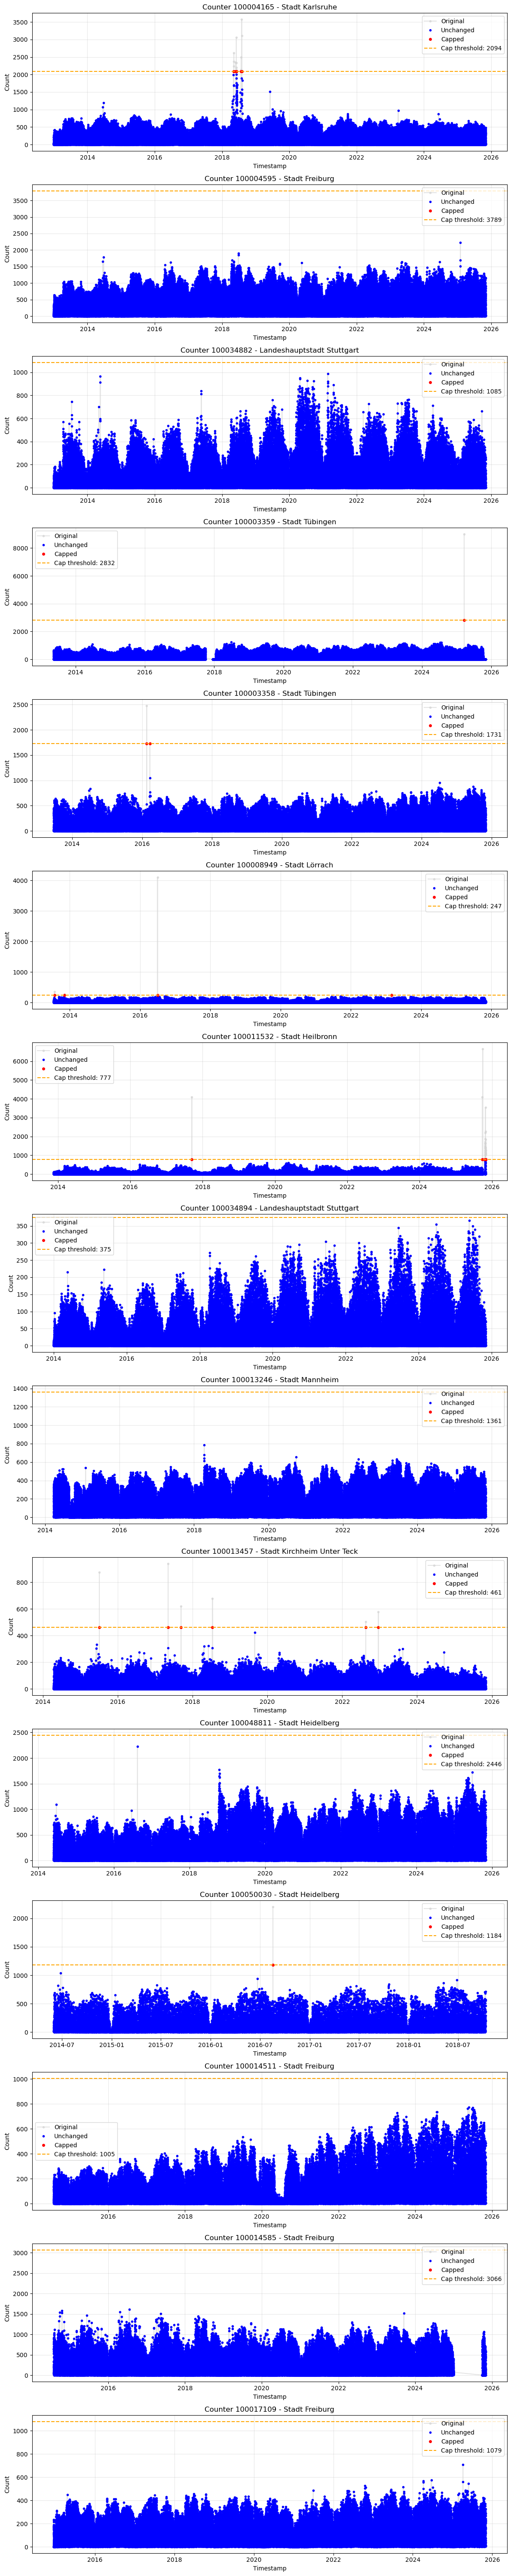

In [7]:
# Plotting the results for each counter
fig, axes = plt.subplots(num_counters, 1, figsize=(12, 4*num_counters))

# Ensure axes is iterable even for single subplot
if num_counters == 1:
    axes = [axes]

for idx, (_, counter_info) in enumerate(counters_info.iterrows()):
    counter_id = counter_info['counter_site_id']
    city = counter_info['city']
    
    # Filter data for this counter
    counter_data_cap = data_cap[data_cap['counter_site_id'] == counter_id].sort_values('timestamp')
    counter_data_clean = data_cleaned[data_cleaned['counter_site_id'] == counter_id].sort_values('timestamp')
    
    # Calculate upper bound for this counter
    Q3 = counter_data_clean['count'].quantile(0.75)
    Q1 = counter_data_clean['count'].quantile(0.25)
    IQR = Q3 - Q1
    upper_bound = Q3 + cap_const * IQR
    
    ax = axes[idx]
    
    # Plot original data (cleaned) in gray
    ax.plot(counter_data_clean['timestamp'], counter_data_clean['count'], 
            'o-', color='lightgray', alpha=0.6, label='Original', markersize=3)
    
    # Plot capped data - different colors for capped vs not capped
    capped_mask = counter_data_cap['count_capped']
    ax.plot(counter_data_cap[~capped_mask]['timestamp'], 
            counter_data_cap[~capped_mask]['count'], 
            'o', color='blue', label='Unchanged', markersize=3)
    ax.plot(counter_data_cap[capped_mask]['timestamp'], 
            counter_data_cap[capped_mask]['count'], 
            'o', color='red', label='Capped', markersize=4)
    
    # Add horizontal line for cap threshold
    ax.axhline(y=upper_bound, linestyle='--', color='orange', 
               label=f'Cap threshold: {upper_bound:.0f}')
    
    ax.set_title(f"Counter {counter_id} - {city}")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ansatz 2:
Die Daten werden Gruppiert in Jahre und dann werden die Quantile für jedes Jahr separat über alle Datenpunkte des entsprechenden Jahres berechnet.

Vorteil: simpel und ermöglicht uns einfach nur extrem hohe Outlier rauszukicken ohne die restlichen Daten zu verändern. Und es berücktsichtigt grob den Trend, sodass der eigentlich kein Problem mehr ist. \
Nachteil: berücksichtigt nicht Jahres- oder Tagesschwankungen/ dass in den Daten Saisonalitäten vorhanden sind die an sich schon starke Variabilität erzeugen. Ein Wert wird mit allen anderen Datenpunkten verglichen unabhängig von z.B. der Tageszeit. Dabei ist es normal, dass zum Beispiel Mittags der Wert viel höher ist als nachts und ist nicht unbedingt ein Outlier. Der Threshold ist dadurch relativ niedrig für Datenpunkte zu Hochzeiten und zu hoch für zum Beispiel Nacht-Zeiten. Aber vielleicht wollen wir hohe Werte Nachts/im Winter ja tolerieren weil wir von Sommerzeiten/Nachmittagen wissen, dass es möglich ist, dass so viele Fahrräder durchfahren. 

In [8]:
#  Function: Cap the outliers by calculating the thresholds in yearly intervals, to account for the trend

# set all median values above Q3 + cap_const·IQR to exactly Q3 + cap_const·IQR (for each counter and year separately)
def cap_counter_by_year(counter_data, values_where="count", cap_const=5):
    # Extract year from timestamp
    counter_data['year'] = counter_data['timestamp'].dt.year
    
    # Calculate bounds for each year
    for year in counter_data['year'].unique():
        year_mask = counter_data['year'] == year
        year_data = counter_data.loc[year_mask, values_where]
        
        Q1 = year_data.quantile(0.25)
        Q3 = year_data.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + cap_const * IQR
        
        # Mark which values were capped for this year
        counter_data.loc[year_mask, f'{values_where}_capped'] = year_data > upper_bound
        
        # Cap values for this year
        counter_data.loc[year_mask, values_where] = np.where(
            year_data > upper_bound, 
            upper_bound, 
            year_data
        )
    
    counter_data.drop('year', axis=1, inplace=True)
    return counter_data

def cap_outliers_by_year(data, values_where="count", cap_const=5):
    return data.groupby('counter_site_id', group_keys=False).apply(
        cap_counter_by_year, values_where=values_where, cap_const=cap_const
    )

In [9]:
# Cap high values with yearly threshold
cap_const_yearly = 3
data_cap_yearly = cap_outliers_by_year(data_cleaned, "count", cap_const=cap_const_yearly) 
#enthält Spalte 'count_capped' die angibt ob der Wert gecappt wurde und Spalte 'count' mit den gecappten Werten

#data_cap.head()

C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\903917758.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[13. 19. 20. ... 25. 11. 19.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  counter_data.loc[year_mask, values_where] = np.where(
C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\903917758.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('counter_site_id', group_keys=False).apply(


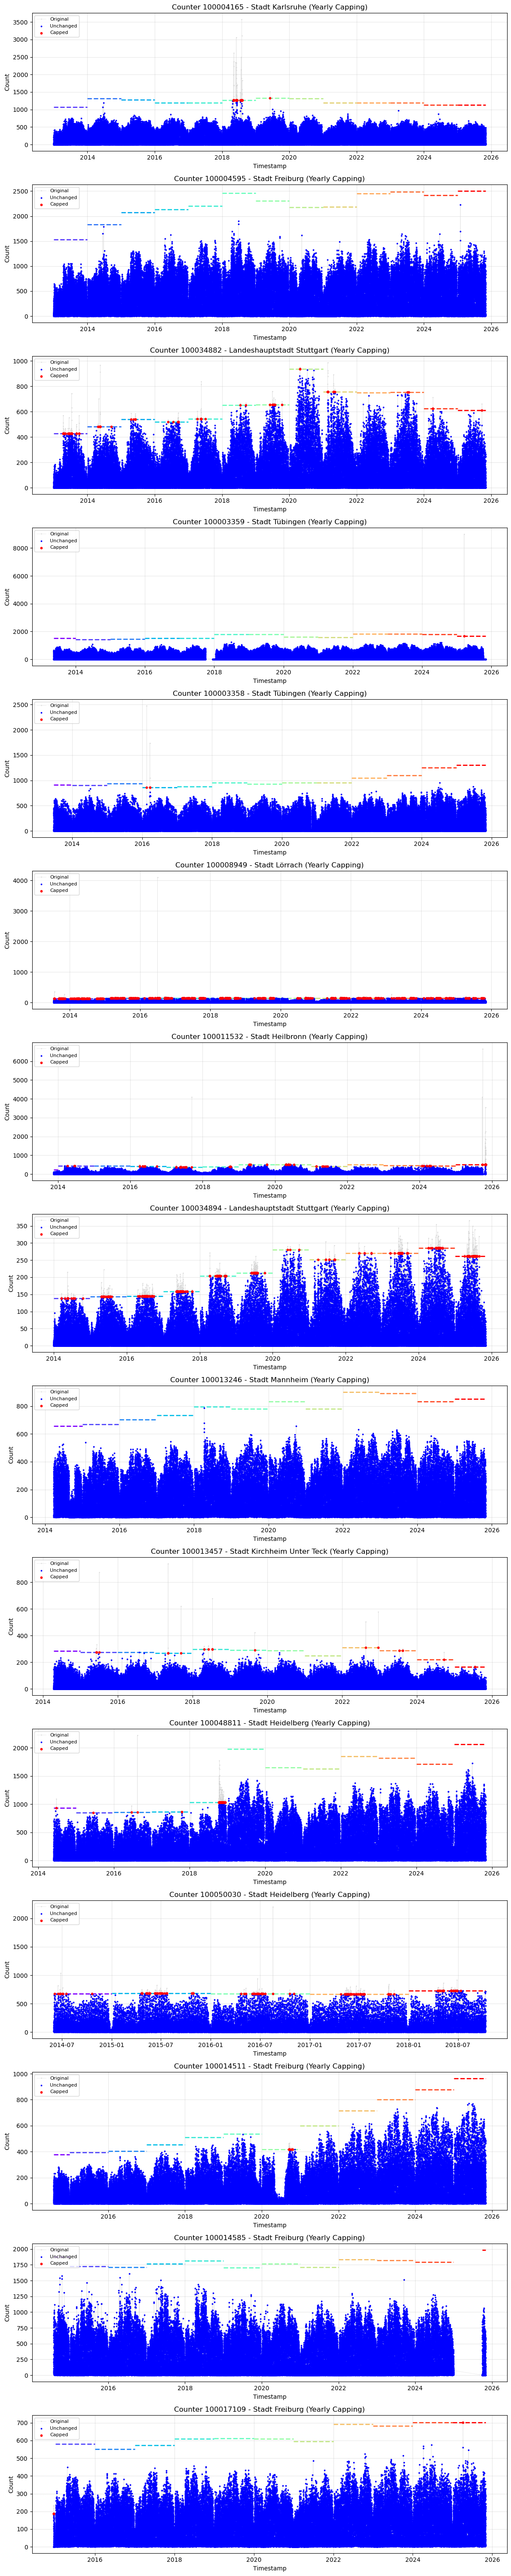

In [10]:
# Plot the yearly capped data with yearly thresholds
fig, axes = plt.subplots(num_counters, 1, figsize=(12, 4*num_counters))

# Ensure axes is iterable even for single subplot
if num_counters == 1:
    axes = [axes]

for idx, (_, counter_info) in enumerate(counters_info.iterrows()):
    counter_id = counter_info['counter_site_id']
    city = counter_info['city']
    
    # Filter data for this counter
    counter_data_cap_yearly = data_cap_yearly[data_cap_yearly['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    counter_data_clean = data_cleaned[data_cleaned['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    
    ax = axes[idx]
    
    # Plot original data (cleaned) in gray
    ax.plot(counter_data_clean['timestamp'], counter_data_clean['count'], 
            'o-', color='lightgray', alpha=0.6, label='Original', markersize=1, linewidth=0.5)
    
    # Calculate and plot yearly thresholds
    counter_data_clean['year'] = counter_data_clean['timestamp'].dt.year
    years = sorted(counter_data_clean['year'].unique())
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))
    
    for year_idx, year in enumerate(years):
        year_mask = counter_data_clean['year'] == year
        year_data = counter_data_clean[year_mask]
        
        Q1 = year_data['count'].quantile(0.25)
        Q3 = year_data['count'].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + cap_const_yearly * IQR
        
        # Plot horizontal line for this year's threshold
        year_start = year_data['timestamp'].min()
        year_end = year_data['timestamp'].max()
        ax.hlines(y=upper_bound, xmin=year_start, xmax=year_end, 
                 linestyle='--', color=colors[year_idx], linewidth=2)
    
    # Plot capped and unchanged data
    capped_mask = counter_data_cap_yearly['count_capped'].astype(bool)
    
    ax.scatter(counter_data_cap_yearly[~capped_mask]['timestamp'], 
               counter_data_cap_yearly[~capped_mask]['count'], 
               color='blue', label='Unchanged', s=3, zorder=4)
    ax.scatter(counter_data_cap_yearly[capped_mask]['timestamp'], 
               counter_data_cap_yearly[capped_mask]['count'], 
               color='red', label='Capped', s=10, zorder=5)
    
    ax.set_title(f"Counter {counter_id} - {city} (Yearly Capping)")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ansatz 3:
Die Quantile/Thresholds werden für jede hour-of-day separat berechnet.

Vorteile: berücksichtigt Tagesschwankungen. Läuft deutlich schneller durch als wenn man auch Jahresschwankungen betrachtet. Und die Quantile sind vermutlich stabiler weil sie über deutlich mehr Datenpunkte berechnet werden. \
Nachteile: Berücksichtigt keine Jahresschwankungen. Eigentlich sind die zu erwartenden Werte ja schon ziemlich stark beeinflusst durch die Jahresschwankungen. 

In [11]:
# Function: Cap outliers based on hour-of-day patterns
def cap_counter_by_hour(counter_data, values_where="count", cap_const=5):
    counter_data = counter_data.copy()
    
    # Extract hour from timestamp
    counter_data['hour'] = counter_data['timestamp'].dt.hour
    
    # Calculate bounds for each hour
    for hour in counter_data['hour'].unique():
        hour_mask = counter_data['hour'] == hour
        hour_data = counter_data.loc[hour_mask, values_where]
        
        Q1 = hour_data.quantile(0.25)
        Q3 = hour_data.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + cap_const * IQR
        
        # Mark which values were capped for this hour
        counter_data.loc[hour_mask, f'{values_where}_capped'] = hour_data > upper_bound
        
        # Cap values for this hour
        counter_data.loc[hour_mask, values_where] = np.where(
            hour_data > upper_bound, 
            upper_bound, 
            hour_data
        )
    
    counter_data.drop('hour', axis=1, inplace=True)
    return counter_data

def cap_outliers_by_hour(data, values_where="count", cap_const=5):
    return data.groupby('counter_site_id', group_keys=False).apply(
        cap_counter_by_hour, values_where=values_where, cap_const=cap_const
    )

In [12]:
# Cap high counter values based on hour-of-day pattern
cap_const_hour = 5
data_cap_hour = cap_outliers_by_hour(data_cleaned, "count", cap_const=cap_const_hour)

C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\2387016694.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 20.  36.  32. ... 103. 102.  87.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  counter_data.loc[hour_mask, values_where] = np.where(
C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\2387016694.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('counter_site_id', group_keys=False).apply(


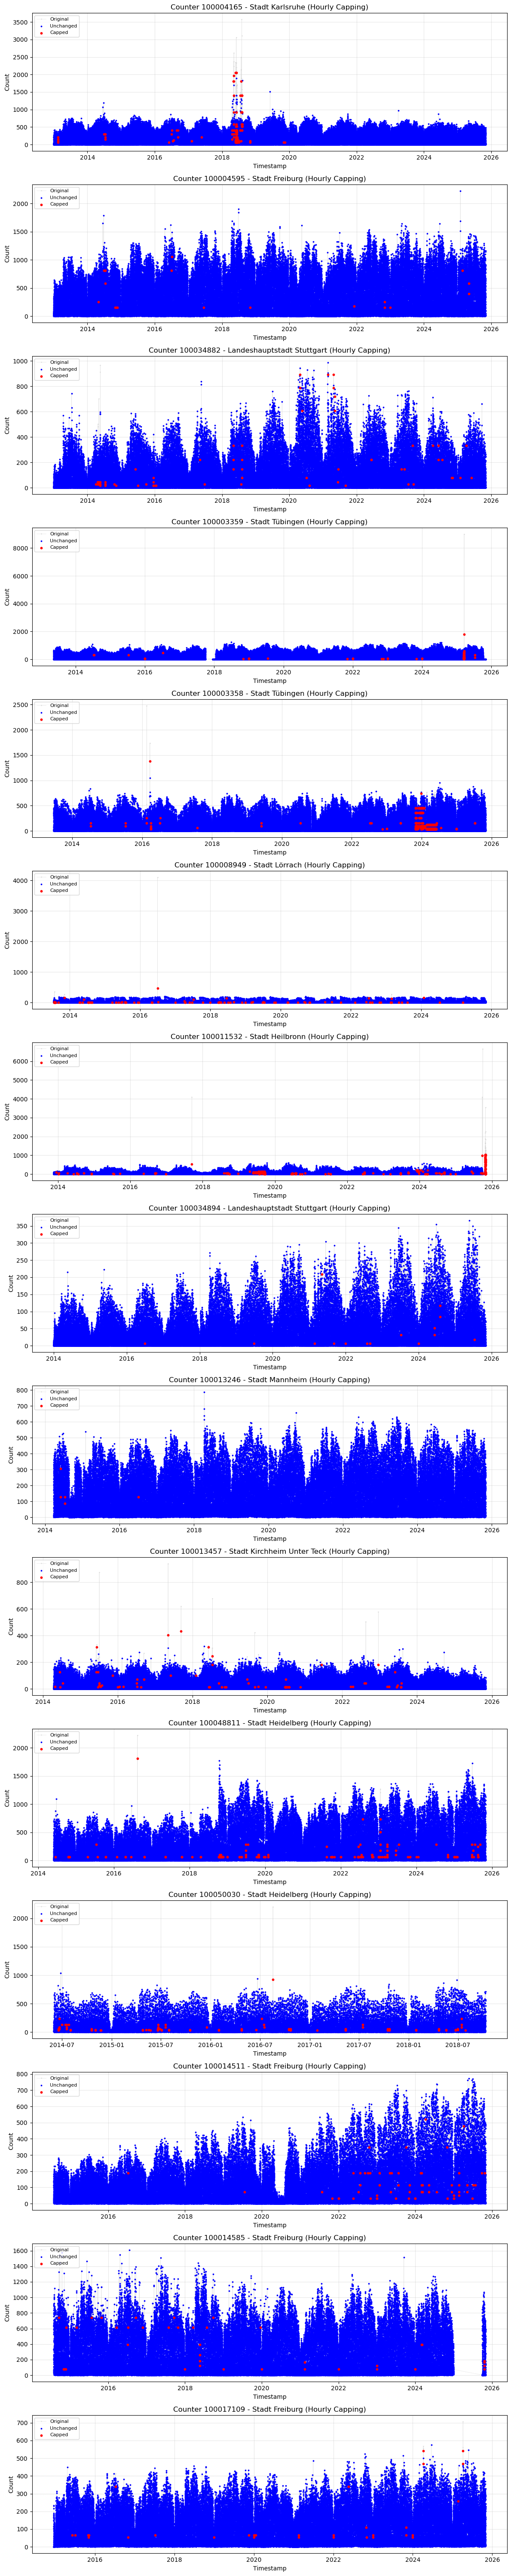

In [13]:
# Plot the hourly capped data
fig, axes = plt.subplots(num_counters, 1, figsize=(12, 4*num_counters))
# Ensure axes is iterable even for single subplot
if num_counters == 1:
    axes = [axes]
for idx, (_, counter_info) in enumerate(counters_info.iterrows()):
    
    counter_id = counter_info['counter_site_id']
    city = counter_info['city']
    
    # Filter data for this counter
    counter_data_cap_hour = data_cap_hour[data_cap_hour['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    counter_data_clean = data_cleaned[data_cleaned['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    
    ax = axes[idx]
    
    # Plot original data (cleaned) in gray
    ax.plot(counter_data_clean['timestamp'], counter_data_clean['count'], 
            'o-', color='lightgray', alpha=0.6, label='Original', markersize=1, linewidth=0.5)
    
    # Plot capped and unchanged data
    capped_mask = counter_data_cap_hour['count_capped'].astype(bool)
    
    ax.scatter(counter_data_cap_hour[~capped_mask]['timestamp'], 
               counter_data_cap_hour[~capped_mask]['count'], 
               color='blue', label='Unchanged', s=3, zorder=4)
    ax.scatter(counter_data_cap_hour[capped_mask]['timestamp'], 
               counter_data_cap_hour[capped_mask]['count'], 
               color='red', label='Capped', s=10, zorder=5)
    
    ax.set_title(f"Counter {counter_id} - {city} (Hourly Capping)")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Ansatz 4:
### Achtung: Dauert sehr lange das auszuführen!
Die Quantile/Thresholds werden für jede hour-of-day und day_of year Kombination einzend berechnet.

Vorteile: berücksichtigt Jahres-und Tagesschwankungen. Extrem hohe Outlier werden ganz gut rausgefiltert, aber auch sehr viel Werte die anscheinend für die Tages- oder Jahreszeit zu hoch sind aber im Vergleich zu andern Zeiten nicht sooo hoch sind. Wollen wir das?
Nachteile: braucht sehr lange um das auszurechnen. Berücksichtigt nicht unbedingt den Trend.


In [14]:
# Function: Cap outliers based on hour-of-day and day-of-year patterns (quantiles and IQR calculated for each hour and day_of_year combination)
def cap_counter_by_time_pattern(counter_data, values_where="count", cap_const=5):
    counter_data = counter_data.copy()
    
    # Extract time features
    counter_data['hour'] = counter_data['timestamp'].dt.hour
    counter_data['day_of_year'] = counter_data['timestamp'].dt.dayofyear
    
    # Initialize capped column
    counter_data[f'{values_where}_capped'] = False
    
    # Group by hour and day_of_year and calculate IQR for each group
    for (hour, day_of_year), group_indices in counter_data.groupby(['hour', 'day_of_year']).groups.items():
        group_data = counter_data.loc[group_indices, values_where]
        
        if len(group_data) > 3:  # Need at least 4 points for meaningful quartiles
            Q1 = group_data.quantile(0.25)
            Q3 = group_data.quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + cap_const * IQR
            
            # Mark and cap outliers
            outlier_mask = group_data > upper_bound
            counter_data.loc[group_indices[outlier_mask], f'{values_where}_capped'] = True
            counter_data.loc[group_indices[outlier_mask], values_where] = upper_bound
    
    counter_data.drop(['hour', 'day_of_year'], axis=1, inplace=True)
    return counter_data

def cap_outliers_by_time_pattern(data, values_where="count", cap_const=5):
    return data.groupby('counter_site_id', group_keys=False).apply(
        cap_counter_by_time_pattern, values_where=values_where, cap_const=cap_const
    )

In [15]:
# Cap high counter values based on hour-of-day and day-of-year patterns
cap_const_pattern = 5
data_cap_pattern = cap_outliers_by_time_pattern(data_cleaned, "count", cap_const=cap_const_pattern)

C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\3690486786.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  counter_data.loc[group_indices[outlier_mask], values_where] = upper_bound
C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\3690486786.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  counter_data.loc[group_indices[outlier_mask], values_where] = upper_bound
C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\3690486786.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '67.5' has dtype incompatible with int64, please explicitly cast to a c

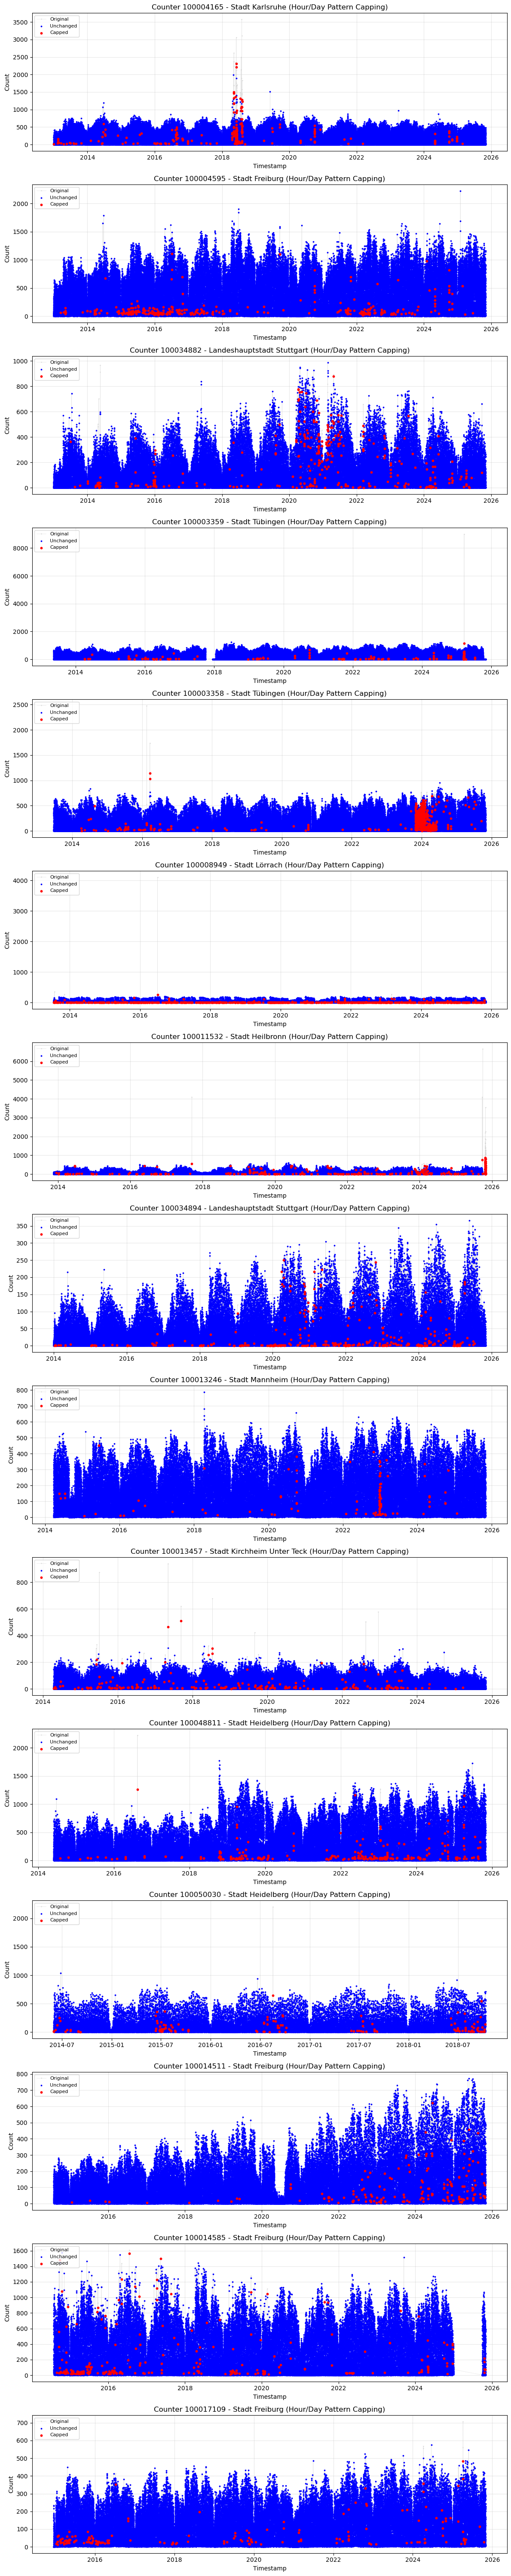

In [16]:
# Plot the pattern-based capped data
fig, axes = plt.subplots(num_counters, 1, figsize=(12, 4*num_counters))

# Ensure axes is iterable even for single subplot
if num_counters == 1:
    axes = [axes]

for idx, (_, counter_info) in enumerate(counters_info.iterrows()):
    counter_id = counter_info['counter_site_id']
    city = counter_info['city']
    
    # Filter data for this counter
    counter_data_cap_pattern = data_cap_pattern[data_cap_pattern['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    counter_data_clean = data_cleaned[data_cleaned['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    
    ax = axes[idx]
    
    # Plot original data (cleaned) in gray
    ax.plot(counter_data_clean['timestamp'], counter_data_clean['count'], 
            'o-', color='lightgray', alpha=0.6, label='Original', markersize=1, linewidth=0.5)
    
    # Plot capped and unchanged data
    capped_mask = counter_data_cap_pattern['count_capped'].astype(bool)
    
    ax.scatter(counter_data_cap_pattern[~capped_mask]['timestamp'], 
               counter_data_cap_pattern[~capped_mask]['count'], 
               color='blue', label='Unchanged', s=3, zorder=4)
    ax.scatter(counter_data_cap_pattern[capped_mask]['timestamp'], 
               counter_data_cap_pattern[capped_mask]['count'], 
               color='red', label='Capped', s=10, zorder=5)
    
    ax.set_title(f"Counter {counter_id} - {city} (Hour/Day Pattern Capping)")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()